Johannes Halkenhaeusser

Minvera Schools at KGI

CS156 - Prof. Sterne

Spring 2020



# Table of Contents

- Understanding the dataset.
    - split test/train
    - Explain why unbalancing is an issue
- Logistic regression
    - Interpret results
    - Use different thresholds
    - Reframe the problem and propose novel metric
- Neural network
    - Compare and contrast to logistic regression
    - Reweighting the loss function
- Conclusion
- HCs
- References

In [343]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras

from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, mean_squared_error

import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

sns.set()

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
import keras.backend as K

from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [522]:
creditcards = pd.read_csv('creditcard.csv')

# Understanding the data.

According to the data source, each row of the data corresponds to a single transation. There are 284,807 transactions in total.
Each transaction's features have been anonymized by performing principle component analysis on them with V1 to V28 as the left over components. This means the data has undergone a dimensionality reduction and features V1-V28 are the dimensions of the data explaining most of the variance. As this done through matrix multiplication where the original matrix can have any size, it is impossible for us to reconstruct the original data set without access to the transforming matrix. Hence, we have to accept that the variables are uninterpretable. Usually, interpretability of the effect of variables on a predicted outcome is one of the biggest advantages of linear or logistic regression. For example, if there was a variable "transaction to crypto-fund" that had a large predictive power in a logistic regression, then we could advise decision makers to block/monitor/restrict those transactions. Should the provider of the dataset have the key (= transformation matrix) to undo the PCA, they could possibly analyze what each component means and use the logist regression output.

We will use two kinds of classifiers, a logistic regression (often deemed as one of the most simple binary classifiers) and a neural network. Both have the advantage that we can receive a probability of each class being a fraud rather than just a binary answer. The neural network's disadvantage is that it is a blackbox. I.e., we do not understand WHY it classifies an answer as 0 or 1, simply because the network of parameters is too complex. 

In [523]:
#underlying shape
print(creditcards.shape)

creditcards.head()


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


###  Transforming some variables

Regressions generally assume that values of the predictor varaibles are normally distributed. The column 'Amount', however, shows a high frequency on low amount transactions and exponentially few transactions with higher amounts (this is quite regular for distributions on monetary values). Consequently, we can do our classifiers a favor by taking the log of the Amount column as shown in the figure below this makes the distribution take on a shape of a normal distribution. 

Text(0.5, 0, 'Log Amount')

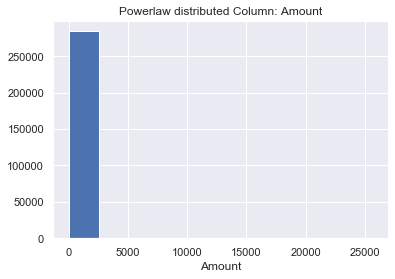

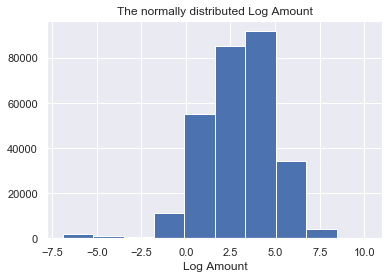

In [862]:
plt.hist(creditcards.Amount)
plt.title('Powerlaw distributed Column: Amount')
plt.xlabel('Amount')
creditcards['logAmount'] = np.log(creditcards['Amount'] + 0.001) #we add 0.1 ct to the transactions to avoid taking the log of 0.

plt.figure()
plt.hist(creditcards['logAmount'])
plt.title('The normally distributed Log Amount')
plt.xlabel('Log Amount')

The time of the transaction is meaningless for any classification task as the only way it is useful would be if there are clusters of fraudulent transactions at a particular time. However, the time here is the time since the first transaction so it does not tell us the time of day and in any future classification, this won't be helpful. The only thing we learn, is that the transactions seem to originate from 2 days. 

To make the transactions interpretable we can take the remainder from dividing by $24*60*60$ (the number of seconds in a day) to obtain somewhat of a "time of day" variable with the day starting at the time of the first transaction. While this removes the information of which day, it gives much more meaningful understanding of what time of day we are looking at. 
As shown in the second figure, we are able to group the transactions frequency into 24 hours that show a plausible pattern of very little transactions during the night time and many more during the day. 

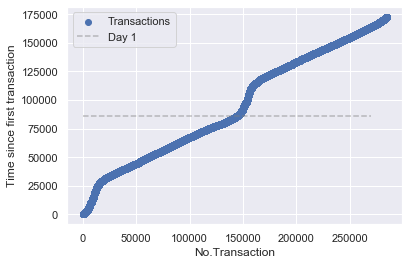

In [867]:
### The linear time line of the data set. 
plt.scatter(range(len(creditcards['Time'])),creditcards['Time'], label = 'Transactions')
plt.hlines(y = 24*60*60, xmin = 0, xmax = 270*10**3, label = 'EOD: Day 1', ls = '--', color = 'grey', alpha = 0.5)
plt.xlabel('No.Transaction')
plt.ylabel('Time since first transaction')
plt.legend()

In [864]:
creditcards['TOD'] = creditcards['Time']%(24*60*60)

Text(0, 0.5, 'Frequency')

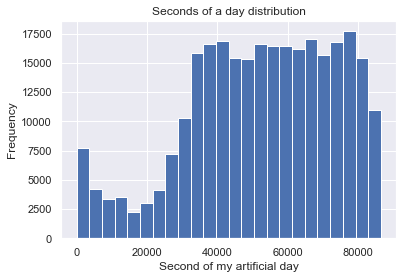

In [527]:
plt.hist(creditcards['TOD'], bins = 24)

plt.title("Seconds of a day distribution")
plt.xlabel('Second of my artificial day')
plt.ylabel('Frequency')

In [868]:
## Define the information we will use for training and testing
X = creditcards[['TOD', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'logAmount']]
Y = pd.DataFrame(creditcards['Class'])

In [869]:
train_feat, test_feat, train_class, test_class = train_test_split(X, Y, test_size=0.15, random_state = 2020)

In [870]:
xtrain = pd.DataFrame(train_feat)
xtrain.head()

,TOD,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,logAmount
55614,47036.0,1.441503,-1.004727,0.793109,-1.240357,-1.814133,-1.080638,-0.986824,-0.255723,-1.869450,...,-0.243513,-0.210964,-0.245143,0.109635,0.708598,0.225033,-0.306844,0.042469,0.035518,3.555377
150373,6794.0,1.983952,0.437064,-1.860304,1.234611,0.255200,-1.573289,0.155254,-0.419144,1.970443,...,-0.203336,-0.132752,0.199746,0.020910,0.202558,0.111868,0.664814,-0.059985,-0.014039,2.510493
125801,77808.0,-2.813563,1.847677,-0.235073,3.115519,-3.475603,4.338663,-0.145000,-8.418194,-1.571494,...,0.511398,-4.354476,1.088456,-0.592518,0.068159,-0.885950,0.057038,0.423148,-0.402807,6.679048
103646,68745.0,-2.118559,1.002092,1.449173,2.715825,0.151568,2.461184,-0.063759,-0.885657,-1.325422,...,-0.765646,1.260185,-0.783653,0.424028,-1.019210,-0.384340,0.084483,0.059434,-0.336510,5.019734
59617,48922.0,0.381413,-2.872468,-1.018285,-1.165107,-1.010000,0.650080,-0.019976,-0.174090,-2.242576,...,0.946184,0.165807,-0.288845,-0.749364,-1.077542,0.552005,-0.046166,-0.077023,0.089549,6.408778


In [871]:
train_class.head()

,Class
55614,0
150373,0
125801,0
103646,0
59617,0


In [543]:
fulltrain = xtrain.copy()
fulltrain['class'] = train_class

In [874]:
#examine the distribution of frauds on transactions 

print('Frauds in Train:', np.sum(train_class.values))
print('Total Transactions in Train:', len(train_class))
print('Ratio Train:', np.sum(train_class.values)/len(train_class)*100, '% \n')
print('Frauds in Test:', np.sum(test_class.values))
print('Total Transactions in Test:', len(test_class))
print('Ratio Test:', np.sum(test_class.values)/len(test_class)*100, '%')

Frauds in Train: 419
Total Transactions in Train: 242085
Ratio Train: 0.17307970340995932 % 

Frauds in Test: 73
Total Transactions in Test: 42722
Ratio Test: 0.17087215018023502 %


The data set is extremely unbalanced. Only 419 of the training transactions are fraudulent (0.17% of 240K). In the test set we also have ~0.17%, which means only 73 transactions out of the roughly 42,000 transactions in the test set are fraudulent. Talk about a needle in a haystack. When we train a classifier and look at accuracy, this will mean that for the test set, a accuracy of ~99% (see below for unrounded value) would mean that we have simply classed all transactions as nonfraudulent and achieved nothing, even though at first glance we have done a superb job of classfying. But accuracy is not what we care about here since we actually care about finding the fraudulent transactions without an army of interns having to siff through every transaction that goes through and validating it. Hence, we want to maximize the cost from siffing through a large number of false positives and cost incurred to us as a bank that is incurred when a fraudulent transaction is not caught (legal fees, the transaction amount that needs to be reimbursed to the customer, and bad press (https://www.ft.com/content/cb06a354-7c97-11e9-81d2-f785092ab560)).

Prefacing any model building, we have to be upfront that any model here will be quite dependent on which fraudulent transactions ended up in the test and train and test set. The test set could e.g. contain a transaction with a very large amount transferred (this will become important later).

In [875]:
# Check the balancing in the data set.

print('Training accuracy if we classed all training transactions as good:',1 - np.sum(train_class.values)/len(train_class.values))
print('Training accuracy if we classed all testing transactions as good:',1 - np.sum(test_class.values)/len(test_class.values))

Training accuracy if we classed all training transactions as good: 0.9982692029659004
Training accuracy if we classed all testing transactions as good: 0.9982912784981977


In [876]:
train_feat.head()

,TOD,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,logAmount
55614,47036.0,1.441503,-1.004727,0.793109,-1.240357,-1.814133,-1.080638,-0.986824,-0.255723,-1.869450,...,-0.243513,-0.210964,-0.245143,0.109635,0.708598,0.225033,-0.306844,0.042469,0.035518,3.555377
150373,6794.0,1.983952,0.437064,-1.860304,1.234611,0.255200,-1.573289,0.155254,-0.419144,1.970443,...,-0.203336,-0.132752,0.199746,0.020910,0.202558,0.111868,0.664814,-0.059985,-0.014039,2.510493
125801,77808.0,-2.813563,1.847677,-0.235073,3.115519,-3.475603,4.338663,-0.145000,-8.418194,-1.571494,...,0.511398,-4.354476,1.088456,-0.592518,0.068159,-0.885950,0.057038,0.423148,-0.402807,6.679048
103646,68745.0,-2.118559,1.002092,1.449173,2.715825,0.151568,2.461184,-0.063759,-0.885657,-1.325422,...,-0.765646,1.260185,-0.783653,0.424028,-1.019210,-0.384340,0.084483,0.059434,-0.336510,5.019734
59617,48922.0,0.381413,-2.872468,-1.018285,-1.165107,-1.010000,0.650080,-0.019976,-0.174090,-2.242576,...,0.946184,0.165807,-0.288845,-0.749364,-1.077542,0.552005,-0.046166,-0.077023,0.089549,6.408778


# Logistic Regression

A logistic regression is a deterministic method by which we determine the probability of an object belonging to a the one of the two classes. This is done by estimating the parameters that solve for the minimum error of the equation for each observation:

$p(x, y, z) = \frac{1}{1 + e^{-(c_0 + c_1*x + c_2*y + c_3*z)}}$

where p is the probability of belonging to class = 1, x, y, and z are features of the observations and c_i are the parameters to be estimated. 
We classify using a threshold above which p has to lie for the observation to belong to class 1. Usually this threshold is set at 0.5.

The big advantage is that the parameters are deterministic and interpretable. For example, should $c_1$ = 2 we know that the log odds increase by 2 of belonging to class = 1, when the feature x of our observations increases by 1. The odds increase by $e^2$. As the parameters are estimated over all observations they are fixed, given the same input. Hence, this is a very simple, yet very effective way of classifying. 


In [886]:

clf = LogisticRegression(random_state=0, max_iter=1500)
clf.fit(train_feat, train_class)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [888]:
print(clf.coef_)
print(np.argmax(abs(clf.coef_)))

[[-1.08984579e-04  1.15076735e-01 -3.01958936e-01 -8.62550021e-02
  -2.33030439e-03 -1.62779255e-01  8.16851702e-03 -1.52235871e-01
  -1.36170350e-01 -6.22677959e-01 -2.48649171e-01  6.29875882e-03
   3.37273231e-02 -3.74230636e-01 -7.79362994e-01  1.37325578e-01
  -2.54757008e-01 -1.76274630e-01 -9.21413386e-03  1.97713423e-01
  -1.57242254e-02  8.94042845e-02  9.43864623e-02 -8.95223191e-04
  -6.43490012e-02 -4.18103657e-02 -9.75547594e-03 -1.00679654e-01
  -5.21371686e-02 -4.25638675e-01]]
14


Above are the coefficients/parameters that were estimated by the logistic regression. It seems like the largest log odds has variable V14. In this case the interpretability does not help us much because, as explained above, V14 itself is uninterpretable. 

Let's check how good the classifier is.

In [895]:
## Evaluating the success of our classifier

def evaluate_method(model, X_t, y_t, test_info, test_labels):
    
    #calculate the accuracy 
    print('Training Accuracy: \t', model.score(X_t, y_t))
    print('Test Accuracy: \t \t', model.score(test_info, test_labels))
    
    #predict both the class and the probability of belonging to the class
    test_predict = model.predict(test_info)
    test_pred_prob = model.predict_proba(test_info)
    
    #calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, test_pred_prob[:,1])

    print(classification_report(test_labels, test_predict))
    
    # Plot confusion matrix
    plt.figure()
    sns.heatmap(confusion_matrix(test_labels, test_predict),annot=True,cbar=True)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    
    #plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr)
    #how much FP do we need for perfect recall?
    plt.vlines(fpr[np.argwhere(tpr == 1)[0]], ymin = 0, ymax = 1, ls = '--', color = "red", alpha = 0.5)
    plt.title(f"ROC \n need FPR of {fpr[np.argwhere(tpr == 1)[0][0]]} for TPR = 1")
    plt.xlabel("False Positive Rate")
    plt.ylabel('True Positive Rate')
    
    #plot threshold to recall curve
    plt.figure()
    plt.plot(thresholds, tpr, label = 'Recall')
    plt.plot(thresholds, fpr, label = 'False Positive Rate')
    plt.xlim(xmin = -.05, xmax = 1.1)
    plt.legend()
    plt.title("Threshold curve")
    plt.xlabel("Threshold")
    plt.ylabel('Rate')

In [896]:
print('Baseline Train:', 1 - np.sum(train_class.values)/len(train_class.values))
print('Baseline Test:', 1 - np.sum(test_class.values)/len(test_class.values))

Baseline Train: 0.9982692029659004
Baseline Test: 0.9982912784981977


Training Accuracy: 	 0.9988640353594812
Test Accuracy: 	 	 0.998782828519264
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42649
           1       0.66      0.59      0.62        73

    accuracy                           1.00     42722
   macro avg       0.83      0.79      0.81     42722
weighted avg       1.00      1.00      1.00     42722



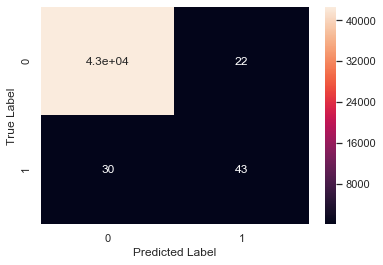

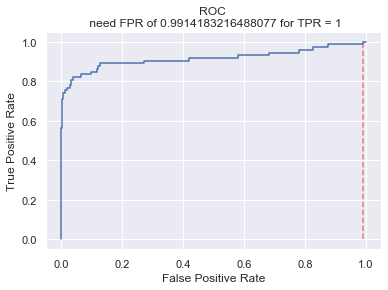

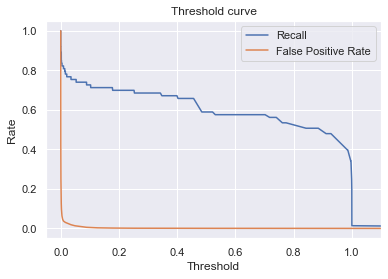

In [897]:
evaluate_method(clf, train_feat, train_class, test_feat, test_class)

As explained above trimuphant champange-drinking in light of the accuracy should be postponed. 

Let's first define the two metrics we may care about:
Precision: how many of those classified in that class actually belong to it?
Recall: how many of those in the class could we find? 

The confusion matrix allows us to inspect the magnitudes of these values. The bottom row may be the most interesting for now: how many fraudsters are missed (bottom left) and how many are identified (bottom right).

Our logistic regression does a good enough job of identifying the non-fraudulent transaction: recall of 100%. However, this is not entirely accurat since we missclassify 30 transaction as being from upright customers when they are fraudulent but considering that we have ~43K transaction in the test set. Still not too bad if we are concerned with false positives.

The most important metric for us however is the recall of fraudulent transactions as we are concerned with finding those in the shadow-hiding fraudsters. 59% recall is terrible. This is concerning given the bad press this could entail...We will use these 59% as our baseline. 

The ROC curve gives us a more probabilistic description of framing the trade-off between false positive and true positive rate. 

The true positive rate (Recall of Fraud) is given by: 

$ TPR = \frac{True Postives}{True Positives + False Negatives}$

The False Positive rate (False alarm) is given by:

$ FPR = \frac{False Positives}{False Postivies + True Negatives}$


As we can see the first 59% recall were pretty easy for our model. If an intern had to go through each transaction that was marked as positive then he only had to go through 22 extra transactions (assuming our intern is a perfect detector of fraud when given the predicted frauds from our logistic regression - not so bad for a day of work). But our poor intern would have also gotten yelled at for those 30 False Negatives the algorithm let slip through that cost the bank a lot of money even though our intern never got to see them.

The ROC tells us how many cases our intern would have to go through in total to find every fraudulent transaction. It turns out to find all of them, we'd need an army of interns that siff through thousands of false positives before hitting that fraudster if we wanted to find all of them. Specifically, we'd need 99% of false positives to find the fraudsters. Given that $ FP = \frac{False Positives}{False Postivies + True Negatives}$, we'd need to exmaine 99.14% of the ~43K transactions which are in the test set... 

### Specifying the problem further

We have now made clear why accuracy is inappropriate, that we are concerned with recall of the fraudster class, and that for this end we need to increase the false positive rate. Throughout this discussion we have worked with rather handwavy descriptions of the __impact__ a false positive and a false negative has on us. However, the savy banker does not actually care to find all frauds but to minimize the cost of frauds on his business. Hence, we need to reframe the problem slightly and should calculate the ideal threshold for our classifier that minimizes our business cost. The better the classifier, the more optimal we can set our threshold. The threshold itself now becomes irrelevant other than, that it tells us what false positive and false negative rate we need to accept. 

To implement our new cost function we have to define the losses associated to the different types of mistakes. 
There are four types of events that can happen:

- True Negative. (no cost)
- False Negative. We have missed a fraudulent transaction: 
    - Each fraudster costs the bank the amount that has been transacted, USD1000 in legal payments and another USD1000 in bad press. While these numbers are arbitrary, they still put considerable weight on a missed classification

- False Positive. Each transaction the algorithm spits out for review costs us 5 minutes of work by our intern who earns an hourly rate of USD 12 
    - false positive costs us USD 1. 
- True Positive: cost of USD 1 (our intern still has to review it)


To estimate how good our classifier is in general we can define $p_1$ as being a fraud and can set up following calculation to find out the average cost per transaction incurred to us: 

$ Expected(T) = \frac{1}{T} \sum_{t = 1}^{T}{[(amount_t + 2000 + 1)*class_t*(1 - p_{1t}) +  p_{1t}]}$

The average expected cost per transaction given the classifier is USD 1.48, a disaster for our bank. Given that we estimated that there are roughly a quarter million transaction in the dataset, it means that we have a huge cost due to fraud...

However, the algorithm should spit out a decision that our intern can work with. I.e. there needs to be a decision if a transaction has to be reviewed given a threshold. 

Hence, we can rewrite our equation from above slightly:

$ Expected(T) = \frac{1}{T} \sum_{t = 1}^{T}{[(amount_t + 2000 + 1)*class_t*(1 - \phi) + \phi]}$

where $\phi$ = 1 if $p_{1t}$ > threshold, and 0 otherwise

In [899]:
## Looking just at the expected mean cost (using the probability not the actual decision boundary)
df_aux = test_feat.copy()
df_aux['class'] = test_class.copy()

df_aux['cost'] = (np.exp(df_aux['logAmount']) + (2000) + 1)*df_aux['class']
df_aux['P1'] = clf.predict_proba(test_feat)[:,1]

df_aux['E_t'] = df_aux['cost']* (1- df_aux['P1']) + df_aux['P1']

print(np.mean((df_aux['E_t'].values)))


1.4840323277600431


In [560]:
def thresholds(model, no_thresholds, data_feat, data_class):
    
    tried_th = []
    expected_costs = []
       
    #build the auxillary dataframe
    df_aux = data_feat.copy()
    df_aux['class'] = data_class.copy()

    df_aux['cost'] = (np.exp(df_aux['logAmount']) + (2000))*df_aux['class']
    df_aux['P1'] = model.predict_proba(data_feat)[:,-1]
        
    #for a number of threshold 
    for tresh_1000 in range(no_thresholds):
        
        thresh = tresh_1000/no_thresholds # get the threshold
        
        tried_th.append(thresh)
     
        df_aux['biggerT'] = (df_aux['P1'] > thresh)
        df_aux['biggerT'] = df_aux.biggerT.astype(int)

        df_aux['E_t'] = df_aux['cost']* (1 - df_aux['biggerT']) + df_aux['biggerT']
        
        expected_costs.append(np.mean((df_aux['E_t'].values)))
        
    return np.array(expected_costs), tried_th

Text(0, 0.5, 'Average cost (USD)')

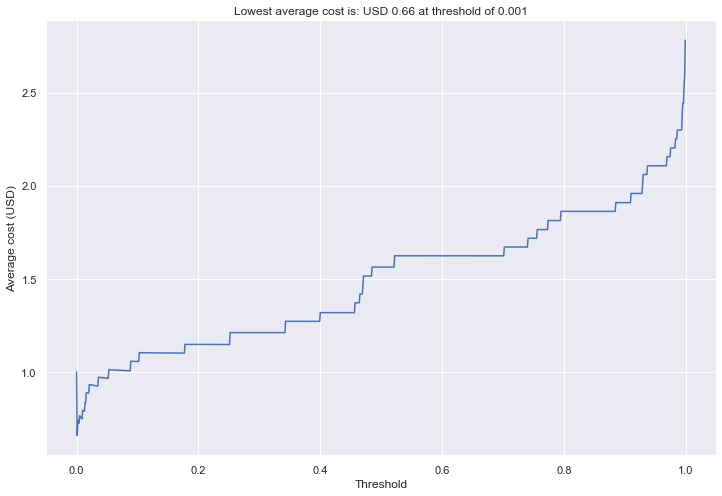

In [561]:
costs_th, ths = thresholds(clf, 1000, test_feat, test_class)
plt.figure(figsize = (12, 8))

plt.plot(ths, costs_th)
plt.title(f'Lowest average cost is: USD {round(costs_th[np.argmin(costs_th)],2)} at threshold of {ths[np.argmin(costs_th)]}')
plt.xlabel('Threshold')
plt.ylabel('Average cost (USD)')


Uff. While the threshold change lets us get our average cost down to 66 ct per transaction this is bad news for our bank because of all the false positives. Let's check out what the confusion matrix tells us about how many cases our intern has to review:

Our intern has to review 1548 false positive cases and we still miss 14 fraudsters.


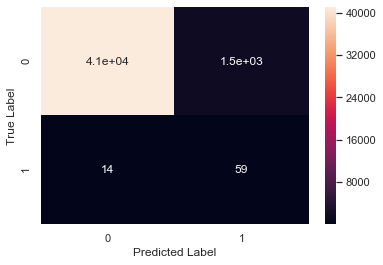

In [563]:
plt.figure()
confusion = confusion_matrix(test_class, clf.predict_proba(test_feat)[:,1] > 0.01)
sns.heatmap(confusion,annot=True,cbar=True)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

print(f'Our intern has to review {confusion[0][1]} false positive cases and we still miss {confusion[1][0]} fraudsters.')

Our classifier needs to improve!
Let's try: 

## A neural network approach

In a neural network allows us to stack functions on top of functions and use gradient descent through back propagation to optimise the parameters of our our network, so that we can get a final output. In lay terms, if we have an observation with feature x, we define a function f(x). The outcome of this function is passed to another function g(f(x)), which is passed on again (and again). The number of functions determines the number of layers. The layer's activation function (e.g. Relu, Sigmoid) determines the gradient, and the output, the number of outputs and parameters to estimate in each layer is determined by the number of neurons in each layer (i.e., if layer f(x) has two neurons, it gives two outputs $f_1(x)$ and $f_2(x)$, which both are fed into the functions of g(f(x)). Every time we pass information through the network, we estimate the loss (how different is the output from its true value). We then propagate the error back wards to adjust each parameter in our neurons in the direction of largest decrease in error (this is backpropagation). Finally, we will have a network of fine-tuned parameters that are adjusted to complement one-another. Notice how we now have a lot more parameters compared to the logistic regression where we had just the number of input features + constant. This makes the model much more flexible, but also at risk of overfitting and completely uninterpretable. We try to prevent overfitting by adding a validation split.

The output layer we will has one neuron a sigmoid activation function which means that the final output is squished on the sigmoid function (the logistic function is an example of the sigmoid function family), that has an S-shape from 0 to 1. Hence, the output is again interpretable as the probability of belonging to class 1 - being a fraudster.

Training the neural network requires specifying a proper loss function. Here we will use binary-cross entropy which compares the predicted class probability with the real class. Specifically, for each sample we calculate: 

$BCE(t, p) =  - (t * log(p) + (1 - t) * log(1 - p)$ 

where $t$ is the target class and $p$ is the probability of belonging to class 1. 
Practically, the larger the difference between the target class, the larger the loss and due to the log statements these the marginal loss increases the more we diverge from an accurate prediction (Chris, 2019). 

To train the neural network, we feed our network the data in batches. Usually the batchsize is kept small so that the memory of our machine does not get used up too and it becomes computationally expensive to adjust the weights during backpropagation for a large batch. However, because our dataset is so imbalanced we need to increase the batch size to increase the proability of getting at least some fraudsters. We will use approximately 5.

In [902]:
#calculate approximate batch size so there are at 3 frauds in each batch

print(5/(np.sum(train_class)/len(train_class)))

#assuming that the fraudsters are evenly distributed in our class

Class    2888.842482
dtype: float64


In [903]:
## create the early stopping
def early_stop():
    return tf.keras.callbacks.EarlyStopping(
        monitor='recall',  ## we will stop if our recall plummets. 
        verbose=1,
        patience=35,
        mode='max',
        #baseline = 0.59, # let's set a baseline of the logistic regression
        restore_best_weights=True) ## <-- Quite essentially we will always take the model with the best recall!

In [912]:
#train neural network

#Using some help from TensorFlow (nd).
#first we define some metrics that allow us to compare the 

def metric_list():
    return [
          keras.metrics.TruePositives(name='tp'), ### record everything that is necessary from the confusion matrix.
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
    ]

#create a function to build and run neural networks
def run_model(max_epochs, neurons, X, Y, shuffle_q = False, class_weights = {0: 1, 1: 1}):
    
    
    nn = Sequential()
    nn.add(Dense(16, input_dim=30, activation='relu')) #add the original layer
    nn.add(Dense(neurons, activation='relu')) 
    nn.add(Dense(1, activation='sigmoid')) #the sigmoid layer gives a logistic regression-esque output.

    nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=metric_list())
    
    nn_hist = nn.fit(X, Y,
                            epochs=max_epochs,   #early stopping may mean less epochs.
                            batch_size=2900,
                            verbose = 0, 
                            validation_split = .2, ## preventing overfitting. With a validation split of 20% we should have roughly 1 fraudster in each validation batch.
                            callbacks= [early_stop()],
                    class_weight = class_weights)
                            
                               
    return nn, nn_hist



In [944]:
#create a slighlty modified version of the evaluate function because of output variability
def evaluate_method_nn(model, X_t, y_t, test_info, test_labels, plot = True):
     
    test_predict = model.predict(test_info)
    test_pred_prob = model.predict_proba(test_info)
    #print(test_pred_prob)
    
    fpr, tpr, thresholds = roc_curve(test_labels, test_pred_prob[:,-1])

    
    #we don't always want to plot everything... 
    if plot:
        
        
        print(classification_report(test_labels, test_pred_prob >.5))
        # Plot confusion matrix
        plt.figure()
        sns.heatmap(confusion_matrix(test_labels, test_pred_prob > 0.5),annot=True,cbar=True)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

        #how much do we differentiate 
        plt.figure()
        plt.title('Probabilities in both classes')
        plt.scatter(test_labels + np.random.uniform(-.1,.1, size = (len(test_labels), 1)), test_pred_prob, marker = '.', alpha = 0.6)
        plt.xticks(ticks = [0, 1])

        #plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr)
        #how much FP do we need for perfect recall?
        plt.vlines(fpr[np.argwhere(tpr == 1)[0]], ymin = 0, ymax = 1, ls = '--', color = "red", alpha = 0.5)
        plt.title(f"ROC \n need {fpr[np.argwhere(tpr == 1)[0]][0]} for TPR = 1")
        plt.xlabel("False Positive Rate")
        plt.ylabel('True Positive Rate')

        #plot threshold to recall curve
        plt.figure()
        plt.plot(thresholds, tpr, label = 'Recall')
        plt.plot(thresholds, fpr, label = 'False Positive Rate')
        plt.xlim(xmin = -.05, xmax = 1.01)
        plt.legend()
        plt.title("Threshold curve")
        plt.xlabel("Threshold")
        plt.ylabel('Rate')
    
    
    ## summarize the evaluation by area under the ROC curve. 
    ## we can compare how similar this is to our other metric: FPR needed for TPR = 1
    ## there should be a negative correlation (we will examine this)
    return fpr[np.argwhere(tpr == 1)[0]][0], auc(fpr, tpr) 

In [915]:
def cross_validate_NN(no_runs, epochs, x, y, plot = False):
    
    #set up a bunch of lists
    models   = []
    n_neuron = []
    all_auc  = []
    
    recall_fpr = []
    costs_min= []
    thresh   = []
    
    tried_networks = 0
    #test a couple of neuron numbers in the middle layer
    for no_neurons in range(6,16,2):
        
        print("Trying second RELU layer with:", no_neurons)
        
        #do some validation rounds
        for val_round in range(no_runs):
            
            
            
            tried_networks += 1
            print("Running model no.:", tried_networks)
            #run the model
            
            md, histo = run_model(epochs, int(no_neurons), x, y, False)
            
            #evaluate model without expected cost
            perfect_recall, auc_rec = evaluate_method_nn(md, train_feat, train_class, test_feat, test_class, plot)
            
            #get the min_cost
            costs_th, ths = thresholds(md, 1000, test_feat, test_class)
            
            #min cost and threshold
            min_cost = costs_th[np.argmin(costs_th)]
            min_c_t = ths[np.argmin(costs_th)]
            
            models.append(md)
            n_neuron.append(no_neurons)
            all_auc.append(auc_rec)
            recall_fpr.append(perfect_recall)

            costs_min.append(min_cost)
            thresh.append(min_c_t)
            
            
    return models, n_neuron, recall_fpr, all_auc, costs_min, thresh

In [917]:
#run a test validation round and get a couple of sample networks
# I did this many times before but would particularly like to document the variety in networks
networks, neuronlist, fpr_perfect_recall, aucs, min_costs, min_thresh = cross_validate_NN(5, 15, train_feat.copy(), train_class.copy())



Trying second RELU layer with: 6
Running model no.: 1
Running model no.: 2
Running model no.: 3
Running model no.: 4
Running model no.: 5
Trying second RELU layer with: 8
Running model no.: 6
Running model no.: 7
Running model no.: 8
Running model no.: 9
Running model no.: 10
Trying second RELU layer with: 10
Running model no.: 11
Running model no.: 12
Running model no.: 13
Running model no.: 14
Running model no.: 15
Trying second RELU layer with: 12
Running model no.: 16
Running model no.: 17
Running model no.: 18
Running model no.: 19
Running model no.: 20
Trying second RELU layer with: 14
Running model no.: 21
Running model no.: 22
Running model no.: 23
Running model no.: 24
Running model no.: 25


The minimal cost is 0.6540101587004353 with threshold 0.986 and 8 neurons


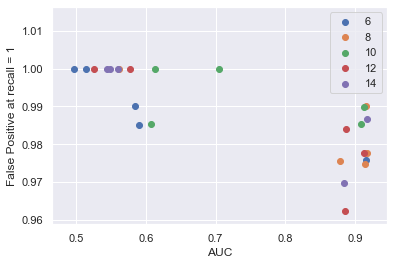

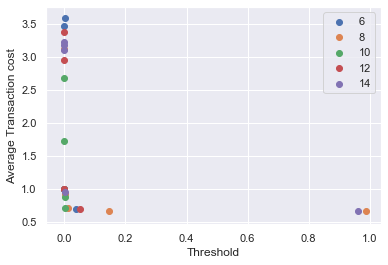

In [918]:
#plot the AUC to FPR at perfect recall to show some negative correlation 
plt.figure()
j = -5
for i in range(5, len(neuronlist)+1,5):
    j += 5
    plt.scatter(aucs[j:i], fpr_perfect_recall[j:i], label = neuronlist[i-1])
    plt.xlabel("AUC")
    plt.ylabel('False Positive at recall = 1')

plt.legend()


#plot the min cost against thresholds
plt.figure()
j = -5
for i in range(5, len(neuronlist)+1,5):
    j += 5
    plt.scatter(min_thresh[j:i], min_costs[j:i], label = neuronlist[i -1])
    plt.xlabel('Threshold')
    plt.ylabel("Average Transaction cost")

plt.legend()
    
print(f'The minimal cost is {min(min_costs)} with threshold {min_thresh[np.argmin(min_costs)]} and {neuronlist[np.argmin(min_costs)]} neurons')





After running training a couple of networks with low numbers of epochs to cross validate a bit, we find that there is considerable variety in the values of recall and of the mean transaction cost associated to each network. While we are able marginally reduce our transaction cost by a couple of cent (mind given the number of operations this can mean a considerable cut in costs).

This makes sense since we have a lot more parameters to train our model with so it is able to classify a lot better. Also, we have specified that we want particularly those weights back that yield the highest recall. So while we are not explicitly training on recall, we at least get a model back that does the best on it. 

However, there is a lot of variability in the mean cost and the AUC even though their set-up is in part the same and we have not run it for many epochs. While we do ask for the model with the best recall, we do not have any insights on narrowing down on particular clusters or on those distributions that have a particularly high amount associated to it. I.e., since we do tell our neural network only to optimize on the binary loss function, to then take the highest recall as a proxy for lowest mean average, the network widely classifies without regard to the fact that we want to cut our cost. It is the particular disadvantage of a neural network that we do not have insights into how each model classifies. 

Most models did best with a low threshold (as we'd expect). However, we also observe some models which are not that good at finding many outliers but those they do find they are really certain of so the threshold increases very high and captures a cluster of high-amount transactions.


For sake of completion and to get a baseline for the next attempt to optimize, we will now train a model with 8 neurons since they did quite well in our tries on minimum average cost per transaction and a more serious amount of epochs. While 14 middle nodes also did quite well, we generally prefer models with less parameters as they are less likely to overfit. The cross validation would of course be better with more model variety, more epochs, and the better loss function. However, our purpose is to explore and contrast methods, metrics, and interpretations rather than building the most advanced and best trained model given that we are constrained in computational capacity, time, and __data__. For example, we may have a unrealistic distributions of our ~70 test fraud transactions. Given that the networks pick up fraudsters in non-deterministic way, the model we build could be picking up only small fish in the test data. Technically, 30 ish fraud transactions would mean that we are approximating the true distribution of the fraudulent transactions. But the distributions could still be off. 

In [940]:
#train a neural network with 3 layers, and 8 neurons on the middle layer. 

unbalanced_nn, histo_f = run_model(250, 8, train_feat, train_class, False)

Restoring model weights from the end of the best epoch.
Epoch 00085: early stopping


In [941]:
unbalanced_nn.summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_501 (Dense)            (None, 16)                496       
_________________________________________________________________
dense_502 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_503 (Dense)            (None, 1)                 9         
Total params: 641
Trainable params: 641
Non-trainable params: 0
_________________________________________________________________


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42649
           1       0.62      0.82      0.71        73

    accuracy                           1.00     42722
   macro avg       0.81      0.91      0.85     42722
weighted avg       1.00      1.00      1.00     42722

Area under ROC: 0.928404109107249


Text(0.5, 12.5, 'Predicted Label')

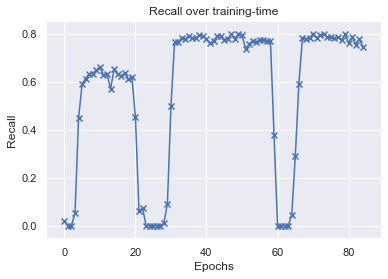

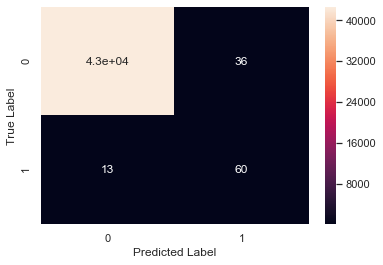

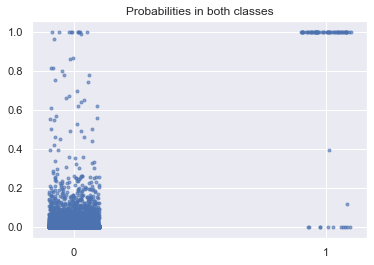

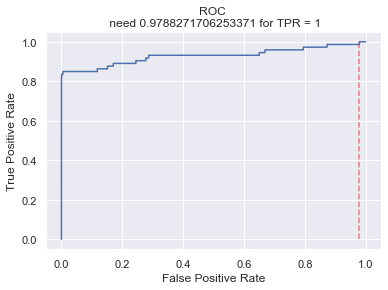

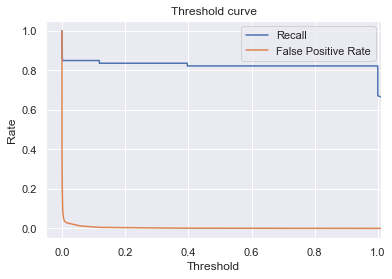

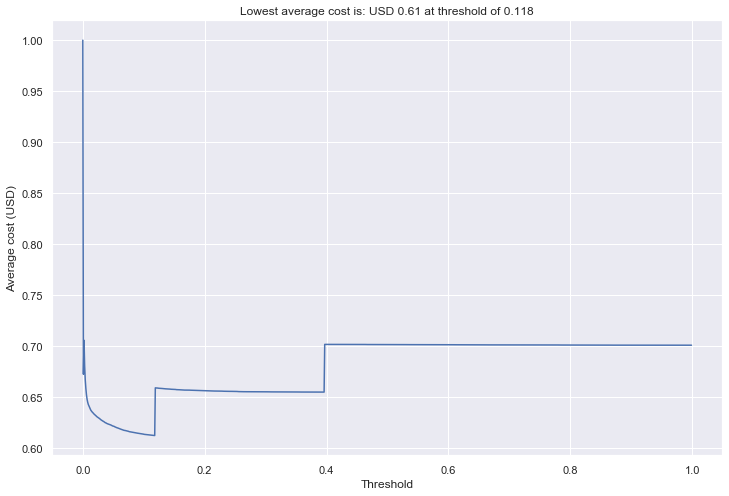

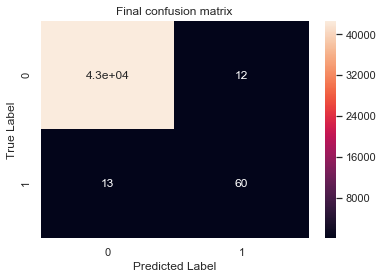

In [945]:

plt.plot(histo_f.epoch, histo_f.history['recall'])
plt.scatter(histo_f.epoch, histo_f.history['recall'], marker = 'x')
plt.title('Recall over training-time')
plt.xlabel("Epochs")
plt.ylabel("Recall")

#evaluate model without expected cost
perfect_recall_f, auc_rec_f = evaluate_method_nn(unbalanced_nn, train_feat, train_class, test_feat, test_class, True)
print("Area under ROC:",auc_rec_f)

#get the min_cost
costs_th_f, ths_f = thresholds(unbalanced_nn, 1000, test_feat, test_class)
plt.figure(figsize = (12, 8))

plt.plot(ths_f, costs_th_f)
plt.title(f'Lowest average cost is: USD {round(costs_th_f[np.argmin(costs_th_f)],2)} at threshold of {ths_f[np.argmin(costs_th_f)]}')
plt.xlabel('Threshold')
plt.ylabel('Average cost (USD)')

            
#min cost and threshold
min_cost_f = costs_th_f[np.argmin(costs_th_f)]
min_c_t_f = ths_f[np.argmin(costs_th_f)]


plt.figure()
confusion = confusion_matrix(test_class, unbalanced_nn.predict_proba(test_feat)[:,-1] >= .96)
sns.heatmap(confusion,annot=True,cbar=True)
plt.title('Final confusion matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')



In [943]:
print(f'Our intern has to review {confusion[0][1]} false positive cases and we still miss {confusion[1][0]} fraudsters.')


Our intern has to review 12 false positive cases and we still miss 13 fraudsters.


Even though our model does quite well on the first metrics (AUC, and false positive rate for perfect recall), it does worse in minimizing the mean transaction cost. This model decreases from 66ct for our logistic regression to 61 ct per transaction! Each cent is a 2400 USD improvement on the 240,000 transactions we went into (about twice our intern's monthly paycheck...).

However, the model is not fantastic. At a really small threshold we have 82% recall. This means the classifier is successfully identifying those 82% to have a high probability of being a fraudulent transaction. We can gradually reduce the cost per transaction by increasing the threshold and lowering our false positive rate. 

The downside can be seen in the scatterplot above: There are 100% - 82% = 16% of lost causes that the network did not pick up on at all. Even at a really low threshold, the network thinks they are good transactions. Further, while most non-fraudulent transactions are distributed towards a low probability, there are still a few with a higher probability further up. (note, I blurred the classes in the scatterplot to make them more observable. There are still only 2 classes!)


### Balancing


Our neural network has done a better job than the logistic regression. Yet, we have not made explicit to the model that there is an enormous imbalance in the data. By using the 'balance' argument in the neural network we reweight each transaction according to the overall balance of classes in the data set during training. This will associate a weight to each of the samples when calculating the loss. We can thus give the model the proportions of the classes so that it will 'pay more attention' to those few fraudulent samples as falsely predicting them becomes really costly to the network. 

In [923]:
## calculate the weights for each class

#we scale by half the length of the training set as this maintains the loss magnitude (TensorFlow, nd.)
weight_0 = float(1/(len(train_class) - np.sum(train_class)) * 0.5*(len(train_class)))
print(weight_0)

weight_1 = float(1/np.sum(train_class) * 0.5*(len(train_class)))
print(weight_1)

0.5008668989431695
288.8842482100239


In [924]:
#run the weigted neural network
weighted_nn, histor_weight = run_model(250, 8, train_feat, train_class, False, class_weights= {0: weight_0, 1: weight_1})



Restoring model weights from the end of the best epoch.
Epoch 00183: early stopping


              precision    recall  f1-score   support

           0       1.00      0.95      0.97     42649
           1       0.03      0.90      0.06        73

    accuracy                           0.95     42722
   macro avg       0.51      0.93      0.52     42722
weighted avg       1.00      0.95      0.97     42722

Area under ROC: 0.9670889519643782


Text(0.5, 12.5, 'Predicted Label')

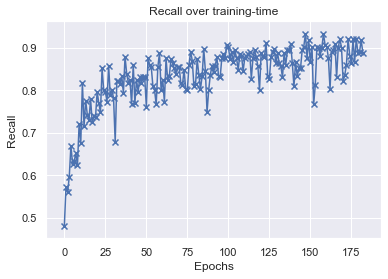

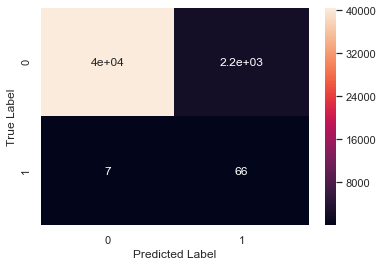

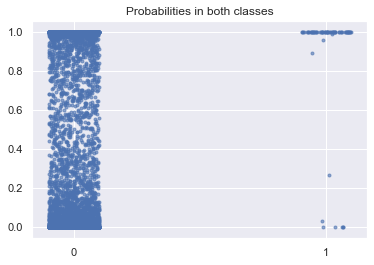

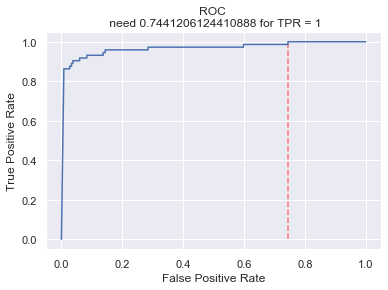

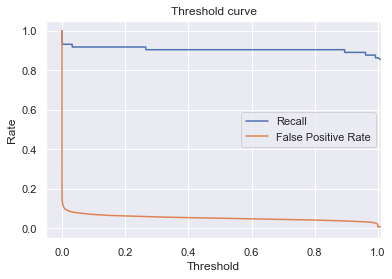

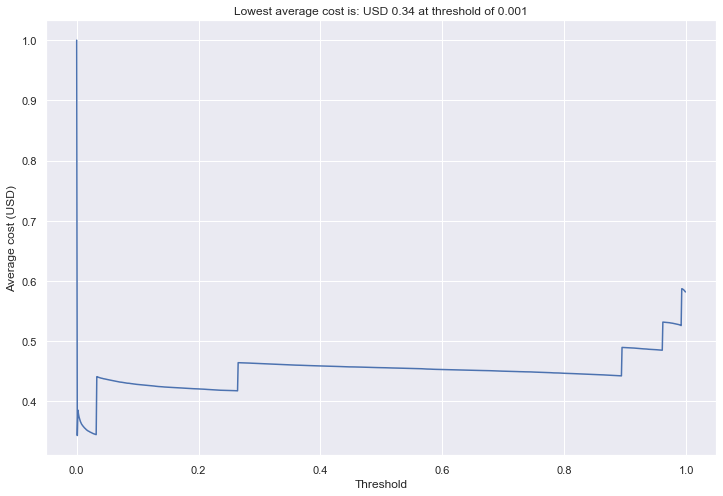

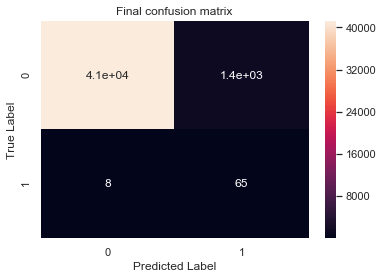

In [946]:
#get the results 
plt.plot(histor_weight.epoch, histor_weight.history['recall'])
plt.scatter(histor_weight.epoch, histor_weight.history['recall'], marker = 'x')
plt.title('Recall over training-time')
plt.xlabel("Epochs")
plt.ylabel("Recall")

#evaluate model without expected cost
perfect_recall_weighted, auc_rec_weighted = evaluate_method_nn(weighted_nn, train_feat, train_class, test_feat, test_class, True)
print("Area under ROC:",auc_rec_weighted)

#get the min_cost
costs_th_weighted, ths_weighted = thresholds(weighted_nn, 1000, test_feat, test_class)
plt.figure(figsize = (12, 8))

plt.plot(ths_weighted, costs_th_weighted)
plt.title(f'Lowest average cost is: USD {round(costs_th_weighted[np.argmin(costs_th_weighted)],2)} at threshold of {ths_weighted[np.argmin(costs_th_weighted)]}')
plt.xlabel('Threshold')
plt.ylabel('Average cost (USD)')

            
#min cost and threshold
min_cost_weighted = costs_th_weighted[np.argmin(costs_th_weighted)]
min_c_t_weighted = ths_weighted[np.argmin(costs_th_weighted)]


plt.figure()
confusion = confusion_matrix(test_class, weighted_nn.predict_proba(test_feat)[:,-1] >= .96)
sns.heatmap(confusion,annot=True,cbar=True)
plt.title('Final confusion matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')



In [926]:
print(f'Our intern has to review {confusion[0][1]} false positive cases and we still miss {confusion[1][0]} fraudsters.')


Our intern has to review 1420 false positive cases and we still miss 8 fraudsters.


Wow! We are able to reduce the cost per transaction down to 34 cts. A much better result than before. In the scatter plot of probabilities for each class, we can see how there are almost no fraud cases with low probability left. While the recall increases for fraud cases, at the 0.5 threshold, we see a very low accuracy (high false positive rate). That's because much less training is dedicated towards getting the non-fraudulent transactions correctly classified. This is also shown in our final confusion matrix: We have 1.420K false positives but therefore we classify everyone else correctly. As discussed above, this all makes sense because our weighted loss function has similarities to the function we have defined to calculate the transaction cost:

Our mean transaction function:

Mean Transaction Cost =$ \frac{1}{T} \sum_{t = 1}^{T}{[(amount_t + 2000 + 1)*class_t*(1 - \phi_t) + \phi_t]}$

The total loss function:

$BCE =  \sum_{t}^T{weight_t * - (class_t * log(p_t) + (1 - class_t) * log(1 - p_t)}$ 

Let's try to reweigth the classes by the monetary loss associated to a wrong classification. I.e., for frauds we have the amount + 2000 (we will use the mean amount as a proxy for now), and for non-frauds 1. 

In [927]:
train_class.head()

,Class
55614,0
150373,0
125801,0
103646,0
59617,0


In [928]:
#Weight for non_fraudsters
cost_weight_0 = 1

df_costs_train_frauds = [train_feat['logAmount'][train_class['Class'] == 1]]
print('Mean Fraudulent Transaction Amount:', np.mean(np.exp(df_costs_train_frauds), axis = 1)[0])

cost_weight_1 = 2000 + np.mean(np.exp(df_costs_train_frauds), axis = 1)[0] + 1
print('Weight Frauds:', cost_weight_1)

Mean Fraudulent Transaction Amount: 121.01374463007157
Weight Frauds: 2122.0137446300714


In [929]:


cost_nn, histor_cost = run_model(250, 8, train_feat, train_class, False, 
                                       class_weights= {0: cost_weight_0, 1: cost_weight_1})


Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping


              precision    recall  f1-score   support

           0       1.00      0.16      0.28     42649
           1       0.00      1.00      0.00        73

    accuracy                           0.17     42722
   macro avg       0.50      0.58      0.14     42722
weighted avg       1.00      0.17      0.28     42722

Area under ROC: 0.9665270219443388


Text(0.5, 12.5, 'Predicted Label')

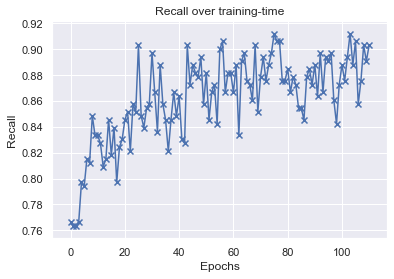

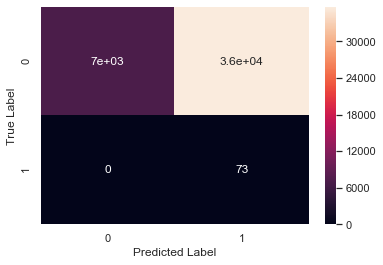

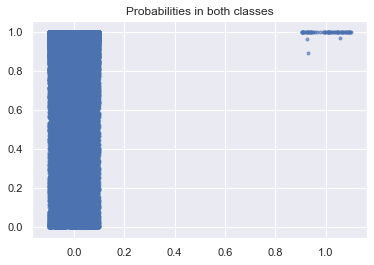

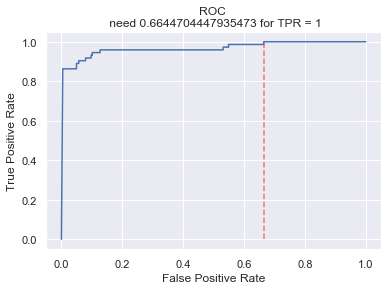

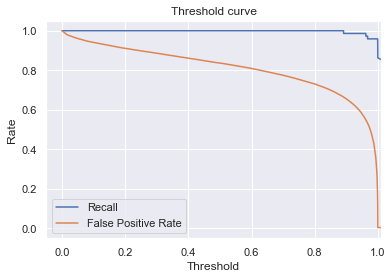

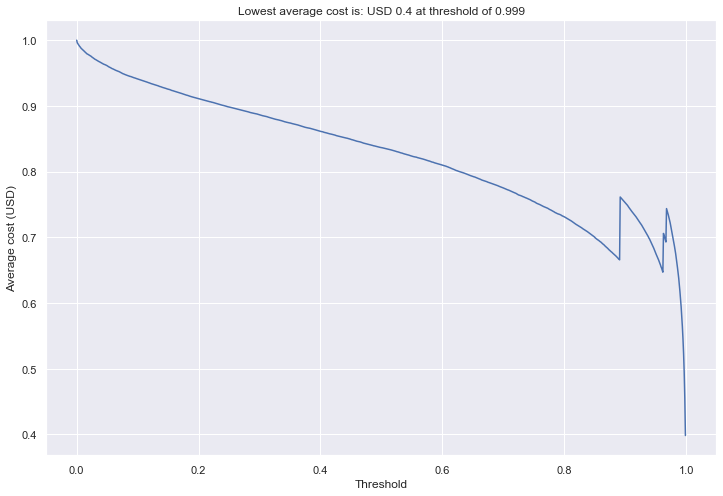

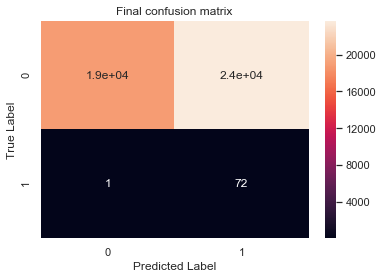

In [930]:
plt.plot(histor_cost.epoch, histor_cost.history['recall'])
plt.scatter(histor_cost.epoch, histor_cost.history['recall'], marker = 'x')
plt.title('Recall over training-time')
plt.xlabel("Epochs")
plt.ylabel("Recall")

#evaluate model without expected cost
perfect_recall_cost, auc_rec_cost = evaluate_method_nn(cost_nn, train_feat, train_class, test_feat, test_class, True)
print("Area under ROC:",auc_rec_cost)

#get the min_cost
costs_th_cost, ths_cost = thresholds(cost_nn, 1000, test_feat, test_class)
plt.figure(figsize = (12, 8))

plt.plot(ths_cost, costs_th_cost)
plt.title(f'Lowest average cost is: USD {round(costs_th_cost[np.argmin(costs_th_cost)],2)} at threshold of {ths_cost[np.argmin(costs_th_cost)]}')
plt.xlabel('Threshold')
plt.ylabel('Average cost (USD)')

            
#min cost and threshold
min_cost_cost = costs_th_cost[np.argmin(costs_th_cost)]
min_c_t_cost = ths_cost[np.argmin(costs_th_cost)]


plt.figure()
confusion = confusion_matrix(test_class, cost_nn.predict_proba(test_feat)[:,-1] >= .96)
sns.heatmap(confusion,annot=True,cbar=True)
plt.title('Final confusion matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')



In [931]:
print(f'Our intern has to review {confusion[0][1]} false positive cases and we still miss {confusion[1][0]} fraudsters.')


Our intern has to review 23695 false positive cases and we still miss 1 fraudsters.


That did not work that well. We can observe that the false positive rate is really high (almost 40K of the 42K rest cases have to be reviewed...). This drove up the average transaction cost. The recall we are able to achieve however, is impeccable! But only at the cost of using an army of our interns to review the cases all over again. It reveals that because we overweighted the cost of falsely classifying fraudsters, we stopped caring about the other transactions which are now spread out with a sigmoid kind distribution (i.e. a lot bunched at the lower end upper end of the 0/1 range). The FPR curve in the Thresholds graph shows how poorly we are able to identify the good transactions. 
It seems like the less heavily re-balanced network, did a better job in at siffing out a large proportion of non-fraudsters. 

# Conclusion

Finally, we found that while the logistic regression can do a good job (especially if we could utilize the data interpretability), but the neural network outperforms it especially on our newly defined metric (lowest mean average cost). Reweigthing had the advantage that we had higher recall on our "important" class but trading off any specificity for those transactions that were non-fraudulent. The best approach according to recall was the cost-reweigthed approach, while the best in terms of our more context specific and easy to communicate metric was the neural network that had class-weight reweighting. We were able to reduce the mean cost per transaction to 34 cts from 66 cts. 

# References

Brownlee, J. (2020, 02 16). Imbalanced Classification With Python (7-Day Mini-Course) . Retrieved from Machine Learning Mastery: https://machinelearningmastery.com/imbalanced-classification-with-python-7-day-mini-course/

Chris. (2019, 10 22). How to use binary & categorical crossentropy with Keras? Retrieved from MACHINECURVE: https://www.machinecurve.com/index.php/2019/10/22/how-to-use-binary-categorical-crossentropy-with-keras/#

itdxer. (2019, 04 05). What is batch size in neural network? Retrieved from StackExchange: https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network

Keras. (2020). Keras: The Python Deep Learning library. Retrieved from Keras: https://keras.io/

Rocca, B. (2019, 01 27). Handling imbalanced datasets in machine learning. Retrieved from towards Data Science: https://towardsdatascience.com/handling-imbalanced-datasets-in-machine-learning-7a0e84220f28

TensorFlow. (2020, 04 02). Classification on imbalanced data. Retrieved from TensorFlow: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

TensorFlow. (2020, 04 23). Overfit and underfit. Retrieved from TensorFlow: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

Wang, S., Liu, W., Wu, J., Cao, L., Meng, Q., & Kennedy, P. J. (2016). Training deep neural networks on imbalanced data sets. 2016 international joint conference on neural networks (IJCNN) (pp. 4368-4374). IEEE.


# HCs

#purpose: Through the reframing of the problem and crafting a metric that is outside of the scope of traditional metrics, I was able to capture the nuance of how profit oriented firms may use the application. Hence, I was able to effectively use the underlying goals and motivations of trying to find the fraudulent transactions to make a more complex analysis of my classifiers. 

#rightproblem: The problem, we are trying to solve here is not to build the ultimate classifier but critically evaluate the classifiers built and explore how we can tackle imbalance using those classifiers. Applying this HC allowed me to focus less on building the classifier with the best output but trying to understand the data set (e.g. making a meaningful transformation of the time variable) and returning meaningful results. 